In [38]:
import pandas as pd
import numpy as np
import re
import platform
import os
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import csv
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from PIL import Image
import time
import math
import wandb
from torchvision import transforms, models
# from utils import *
import matplotlib.pyplot as plt
import random

# Add the path to the feature_extraction directory
sys.path.append(os.path.abspath('../feature_extraction/image_features_extraction'))

# Now you can import Img2Vec
from Img2Vec import Img2Vec

In [39]:
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda")
# to use gpu

True


In [40]:
EMBEDDING_DIM = 128
HIDDEN_DIM = 512
NUM_EPOCHS = 1000
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
CAPTIONS_LENGTH =30
MAX_PLATEAU_COUNT = 50
NUM_CYCLES = 3
NUM_WORKERS = 2
DROP_OUT = 0.5

In [41]:
PROJECT_DIR = '../' 
IMAGE_PATH = os.path.join('../', 'data', 'flickr8k', 'Images')
CAPTIONS_FILE = os.path.join('../', 'data', 'flickr8k', 'captions.txt')
# EMBEDDING_FILE = '../embedding/glove-wiki-gigaword-100.txt'
CHECKPOINT_PATH = os.path.join(PROJECT_DIR,'models','glove_lstm_3.pth')
CAPTIONS_PATH = os.path.join(PROJECT_DIR,'split_data')

In [42]:
df = pd.read_csv(CAPTIONS_FILE, sep=',')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333 at 0x7F11B3C13CB0>
100    Two different breeds of brown and white dogs p...
101    Two dogs are making a turn on a soft sand beach .
102          Two dogs playing in the sand at the beach .
103               Two dogs playing together on a beach .
104        Two large tan dogs play along a sandy beach .
Name: caption, dtype: object


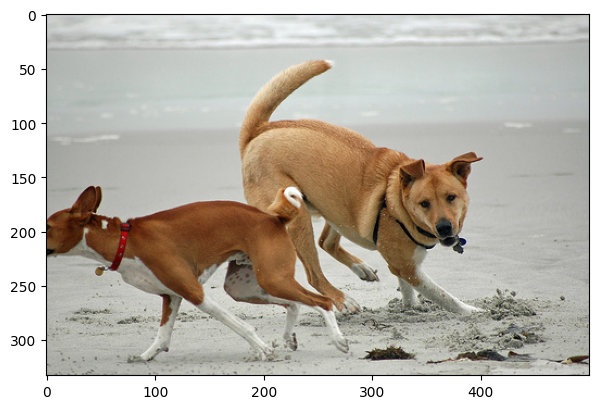

In [43]:
img = Image.open(os.path.join(IMAGE_PATH, df['image'][100]))
print(img)
plt.figure(figsize=(7, 7))
plt.imshow(img)
print(df['caption'][100:105])

In [44]:
def mapping(file_path):
    ''' Create a dictionary to map 1 image with multiple caps ''' 
    with open(file_path, 'r') as f:
        next(f)
        captions_doc = f.read()
    
   
    mapping = {}
    for line in tqdm(captions_doc.split('\n')):
        img_and_cap = line.split(',')
        # if len(line) < 2:
        #     continue
        image_id, caption = img_and_cap[0], img_and_cap[1:]
        # convert caption list to string
        caption = " ".join(caption)
        if image_id not in mapping:
            mapping[image_id] = []
        # store the caption
        mapping[image_id].append(caption)
    return mapping
train_mapping = mapping(os.path.join(CAPTIONS_PATH, 'train.txt'))
val_mapping = mapping(os.path.join(CAPTIONS_PATH, 'val.txt'))
test_mapping = mapping(os.path.join(CAPTIONS_PATH, 'test.txt'))
print(len(train_mapping), len(val_mapping), len(test_mapping))

all_mapping = train_mapping | val_mapping


100%|██████████| 4050/4050 [00:00<00:00, 1064544.16it/s]

6473 810 811


In [45]:
def clean_and_tokenize(cap):
    cap = cap.strip('"')
    cap = cap.split()
    # convert to lower case
    cap = [word.lower() for word in cap]
    cap = [word for word in cap if re.match(r'^[a-zA-Z-]+$', word)]
    cap = ' '.join([word for word in cap if len(word) >0])
    cap = cap.split()
    return cap

print(clean_and_tokenize('"Long-necked , flying white bird grazes water with black legs ."'))


['long-necked', 'flying', 'white', 'bird', 'grazes', 'water', 'with', 'black', 'legs']


In [46]:
all_captions = []
for key in all_mapping:
    for caption in all_mapping[key]:
        all_captions.append(caption)
print(len(all_captions))
all_captions[:6]
max_length = max(len(caption.split()) for caption in all_captions)
max_length



36404


37

In [47]:
def TrainDescriptionTokens(mapping = all_mapping):
    number_of_train_lines = 0
    train_token_to_occurrences_dict = {}
    
    for image_id, captions in mapping.items():
        for caption in captions:
            tokens = clean_and_tokenize(cap = caption)
            # Count the occurrences of each token
            for token in tokens:
                if token in train_token_to_occurrences_dict:
                    train_token_to_occurrences_dict[token] += 1
                else:
                    train_token_to_occurrences_dict[token] = 1
            
            number_of_train_lines += 1
    print(f"TrainDescriptionTokens(): number_of_train_lines = {number_of_train_lines}")
    with open(os.path.join('../', 'data', 'occurrence_train.txt'), "w") as f:
        for token, occurrences in train_token_to_occurrences_dict.items():
            f.write(f"{token}\t{occurrences}\n")

    return train_token_to_occurrences_dict
train_token_to_occurrences_dict = TrainDescriptionTokens(all_mapping)
# print(len(train_token_to_occurrences_dict))
# 

TrainDescriptionTokens(): number_of_train_lines = 36404


In [48]:
vocabulary_filepath = os.path.join(PROJECT_DIR, 'data', 'vocab.txt')
sorted_tokens = sorted(train_token_to_occurrences_dict.items(), key=lambda x: x[1], reverse=True) 
sorted_tokens =  sorted_tokens
with open(vocabulary_filepath, 'w+') as output_file:
    output_file.write("index,word,frequency\n")
    for index, token in enumerate(sorted_tokens):
        output_file.write("{},{},{}\n".format(index, token[0], token[1]))

In [49]:
def LoadVocabulary(vocabularyFilepath = vocabulary_filepath):
    word_to_index_dict = {}
    index_to_word_dict = {}
    vocabDf = pd.read_csv(vocabularyFilepath)
    for i, row in vocabDf.iterrows():
        index = row['index']
        word = row['word']
        word_to_index_dict[word] = index
        index_to_word_dict[index] = word
    return word_to_index_dict, index_to_word_dict
word_to_index_dict, index_to_word_dict = LoadVocabulary(vocabulary_filepath)
description_maximum_length = max_length

In [50]:
def ConvertTokensListToIndices(tokens, word_to_index_dict, ):
    ''' Convert all the token of a caption of an image to ârray of occurrence'''
    indices = [0] * len(tokens)           

    for token_idx, token in enumerate(tokens):
        index = word_to_index_dict.get(token,)
        indices[token_idx] = index
    return indices

pretokenized_descriptions_filepath = os.path.join(PROJECT_DIR, 'data', 'token_describ.txt')

with open(pretokenized_descriptions_filepath, 'w+') as outputFile:


    # Loop through the lines of the descriptions file
    with open(os.path.join(CAPTIONS_PATH, 'train.txt'), 'r') as descriptionsFile:

        for line in descriptionsFile.readlines()[1:]:
            line = line.strip()
            line = line.split(',')
            # print(line)
            image_filename, description = line[0], line[1]
            # Tokenize the description
            tokens = clean_and_tokenize(description)

            # Convert the list of tokens to a list of indices
            indices = ConvertTokensListToIndices(tokens,
                                                 word_to_index_dict,
                                                 )
            outputFile.write(image_filename)
            for i in range(len(indices)):
                outputFile.write(",{}".format(indices[i]))
            outputFile.write("\n")

In [51]:
# Assuming the data is stored in a text file named 'data.txt'  

all_description_indices = []  

# Read the file  
with open(pretokenized_descriptions_filepath, 'r') as file:  
    for line in file:  
        # Split each line by commas  
        parts = line.strip().split(',')  # Split by commas  
        # Store the first part as a string (filename) and the rest as integers  
        filename = parts[0]  # The first element is a string (filename)  
        indices = list(map(int, parts[1:]))  # Convert the remaining parts to integers  
        # Append as a tuple (filename, indices)  
        all_description_indices.append(indices)  

# Print the first two entries in the all_description_indices list  
print("all_description_indices[0:2] = {}".format(all_description_indices[0:2]))

all_description_indices[0:2] = [[0, 6, 4, 3862, 19, 0, 528, 711, 299, 0, 402, 1, 25, 140, 7, 4949], [12, 5, 11, 6, 1390, 147, 1689]]


In [52]:
# context mean x words around important word
class ContextToWordDataset(Dataset):
    def __init__(self,
                 all_description_indices,
                 index_to_word_dict,
                 word_to_index_dict,
                 contextLength):
        self.all_description_indices = all_description_indices
        self.index_to_word_dict = index_to_word_dict
        self.word_to_index_dict = word_to_index_dict
        self.contextLength = contextLength

    def __len__(self):
        return len(self.all_description_indices)
    
    def __getitem__(self, idx):
        ''' The method below will return a center word, and several context words around (in indices)'''
        description_indices = self.all_description_indices[idx]        # get cap but presentation is full of indices from created vocab
        last_acceptable_center_index = len(description_indices) - 1          # prevent the center word is out of bound
        
        for position, index in enumerate(description_indices):
            last_acceptable_center_index = position
    
        target_idx = random.choice(range(last_acceptable_center_index+1))

        
        context_around_idxs_Tsr = torch.zeros((2 * self.contextLength), dtype=torch.long)
        
        running_idx = target_idx - int(self.contextLength)    # maybe negative      
        counter = 0
        
        # consider all word around target
        while counter < 2 * self.contextLength:
            if running_idx != target_idx:
                # prevent index is negative or out of bound
                if running_idx >= 0 and running_idx < len(description_indices):
                    context_around_idxs_Tsr[counter] = description_indices[running_idx]
                counter += 1
            running_idx += 1
        target_center_word_idx = description_indices[target_idx]
        if target_center_word_idx >= len(self.word_to_index_dict):
            raise ValueError(f"Invalid target index: {target_center_word_idx}")
        return context_around_idxs_Tsr,  target_center_word_idx
        

all_dataset = ContextToWordDataset(all_description_indices, index_to_word_dict,
                word_to_index_dict, contextLength=3)


In [53]:
# random.seed(1)
sample_data_0 = all_dataset[0]    # test one cap
sample_words_0 = [index_to_word_dict[i] for i in sample_data_0[0].tolist()]        # change to words through indices
center_word_0 = index_to_word_dict[sample_data_0[1]]
print ("sample_words_0 = {}; center_word_0 = {}".format(sample_words_0, center_word_0))
sample_data_1 = all_dataset[1]
sample_words_1 = [index_to_word_dict[i] for i in sample_data_1[0].tolist()]
center_word_1 = index_to_word_dict[sample_data_1[1]]
print ("sample_words_1 = {}; center_word_1 = {}".format(sample_words_1, center_word_1))

sample_words_0 = ['an', 'area', 'with', 'a', 'a', 'a']; center_word_0 = pinestraw
sample_words_1 = ['dog', 'grabs', 'tree', 'a', 'a', 'a']; center_word_1 = limb


In [54]:
class CenterWordPredictor(nn.Module):
    def __init__(self, vocabulary_size, embedding_dimension):    # vocab size = len(word_to_index_dict)
        super(CenterWordPredictor, self).__init__()
        # create an Embedding Layer
        self.embedding = torch.nn.Embedding(vocabulary_size, embedding_dimension)
        # create a Linear layer
        self.decoderLinear = torch.nn.Linear(embedding_dimension, vocabulary_size)           #?
        self.embedding_dim = embedding_dimension
        self.embedding_dimension = embedding_dimension
    def forward(self, contextTsr):
        '''
        processes the context tensor to compute the logits for each word in the vocabulary, 
        representing the model's prediction of the center word based on the provided context.
        '''
        if torch.any(contextTsr >= len(self.embedding.weight)):
            raise ValueError("Index out of bounds in context tensor")
        embedding = self.embedding(contextTsr)  # (batch_size, context_length, embedding_dimension)
        # Average over context words: (batch_size, context_length, embedding_dimension) 
        embedding = torch.mean(embedding, dim=1)
        # -> (batch_size, embedding_dimension): a reprenstative vector for context_tensor
        
        
        # Decoding, weight, bias in this layer will be random, loss function and backpropagate will fix them later
        outputTsr = self.decoderLinear(embedding)   # logit of each word, size (N, vocab_size)
        return outputTsr
vocabulary_size = len(word_to_index_dict)
print(f"Vocabulary size: {vocabulary_size}")
embedding_dimension = 124  
word_embedder = CenterWordPredictor(vocabulary_size, embedding_dimension)
if use_cuda:
    word_embedder = word_embedder.cuda()

Vocabulary size: 8425


In [55]:
# import wandb

# wandb.init(
#     project = "ProjectContextWords",
#     config={
#         "learning_rate": 0.0001,
#         "batch_size": 32,
#         "epochs": 1000,
#         "embedding_dim": 124,
#         "optimizer" : "ADAM",
#         "train_ratio":0.8,
#         "val_ratio": 0.1,

# })

In [56]:
model_embedding_path = os.path.join(PROJECT_DIR, 'models','checkpoints' 'word_embedder_model.pth')

In [57]:
# random.seed(1)
# '''
# Model will be trained to predict centerword from context.
# Backpropagation to fix the weight, bias in 2 matrices above
# Create a model that obtain an embedding matrix of each word
# '''
# word_embedder_parameters = filter(lambda p: p.requires_grad, word_embedder.parameters())
# # Lọc và giữ lại chỉ những tham số của mô hình có requires_grad=True, 
# # tức là các tham số mà mô hình cần tối ưu trong quá trình huấn luyện.

# optimizer = torch.optim.Adam(word_embedder_parameters, lr=0.0001)

# # logit will be passed to lossFcn, inside will have softmax
# lossFcn = nn.CrossEntropyLoss()
# all_dataloader = DataLoader(all_dataset, batch_size=32, shuffle=True) # when call, return one batch dataset

# lowestTrainLoss = sys.float_info.max
# for epoch in range(1,1000+1):     # put max epoch around 1000
#     word_embedder.train()
#     loss_sum = 0.0
#     number_of_batches = 0        # num batches have been sent
#     for (context_around_idxs_Tsr, target_center_word_ndx) in all_dataloader:
#         if number_of_batches % 50 == 0 and number_of_batches > 0:
#             print (".", end="", flush=True)
#         if use_cuda:
#             context_around_idxs_Tsr = context_around_idxs_Tsr.cuda()
#             target_center_word_ndx = target_center_word_ndx.cuda()
            
#         predicted_center_word_ndx = word_embedder(context_around_idxs_Tsr)

#         optimizer.zero_grad()
        
#         # print(predicted_center_word_ndx.shape)  # Should be (N, vocab_size)
#         # print(target_center_word_ndx.shape)    # Should be (N,)
#         loss = lossFcn(predicted_center_word_ndx, target_center_word_ndx)
#         loss.backward()
        
#         optimizer.step()
        
#         loss_sum += loss.item()
#         number_of_batches += 1
#     train_loss = loss_sum/number_of_batches
#     if train_loss < lowestTrainLoss:
#         lowestTrainLoss = train_loss
#         torch.save(word_embedder.state_dict(), model_embedding_path)
#     print ("\nepoch {}: train_loss = {}".format(epoch, train_loss))
#     # wandb.log({'Train_loss': train_loss})
# # wandb.finish()


In [58]:
import shutil

# Đường dẫn gốc của file
source_path = os.path.join(PROJECT_DIR,"models/checkpoints/word_embedder_model.pth")

# Đường dẫn mới cho file copy
destination_path = os.path.join(PROJECT_DIR,"models/checkpoints/word_embedder_model_copy.pth")

# Sao chép file
shutil.copy(source_path, destination_path)

print(f"File đã được sao chép từ {source_path} đến {destination_path}")

File đã được sao chép từ ../models/checkpoints/word_embedder_model.pth đến ../models/checkpoints/word_embedder_model_copy.pth


In [59]:
word_embedder = CenterWordPredictor(vocabulary_size, embedding_dimension)
model_embedding_path_copy = destination_path
word_embedder.load_state_dict(torch.load(model_embedding_path_copy))

# Trích xuất ma trận embeddings
word_embeddings = word_embedder.embedding.weight.data.cpu().numpy()  # Chuyển về numpy array nếu cần
word_to_embedding = {word: word_embeddings[index] for word, index in word_to_index_dict.items()}

# Kiểm tra embedding của một số từ
# example_words = ["hello", "world", "<PAD>"]
# for word in example_words:
#     if word in word_to_embedding:
#         print(f"Embedding for '{word}': {word_to_embedding[word]}")
#     else:
#         print(f"'{word}' not found in vocabulary.")
if use_cuda:
    word_embedder = word_embedder.cuda()

In [60]:
current_embeddings = word_embedder.embedding.weight.data.cpu().numpy()  # Lấy embeddings hiện tại từ model
current_vocab_size, current_embedding_dim = current_embeddings.shape
print("Current shape:", current_vocab_size, current_embedding_dim) 

vocab, ebd = zip(*word_to_embedding.items())
embeddings = []
vocab = list(vocab)  # Danh sách từ
ebd = list(ebd)
embeddings = []
for i in range(len(ebd)):
    i_embeddings = list(ebd[i])  # Chuyển numpy array thành list
    i_embeddings.extend([0.0, 0.0, 0.0, 0.0])  # Thêm 4 chiều mới
    embeddings.append(i_embeddings)

vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)

unk_embedding = np.mean(embs_npa, axis=0).tolist()

dim = embs_npa.shape[1]
sos_embedding = [0.0] * dim
sos_embedding[-3] = 1.0
eos_embedding = [0.0] * dim
eos_embedding[-2] = 1.0
pad_embedding = [0.0] * dim
pad_embedding[-4] = 1.0
# unk_embedding = [0.0] * dim
# unk_embedding[-1] = 1.0

# Update vocab and embeddings
vocab = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"] + vocab
embeddings = [pad_embedding, sos_embedding, eos_embedding, unk_embedding] + embeddings

vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)
print("UPdated_shape", len(vocab_npa), len(embs_npa[0]))

Current shape: 8425 124
UPdated_shape 8429 128


In [61]:
from numpy import nonzero

def clean(cap):
    # cap = cap.strip('"')
    # # tokenize
    # cap = cap.split()
    # # convert to lower case
    # cap = [word.lower() for word in cap]
    # # remove tokens with numbers in them
    # # cap = [word for word in cap if word.isalpha()]    long-neck be deleted
    # cap = [word for word in cap if re.match(r'^[a-zA-Z-]+$', word)]
    # # cap = '<SOS> ' + ' '.join([word for word in cap if len(word) >0]) + ' <EOS>'
    # cap = ' '.join([word for word in cap if len(word) >0])
    return cap

def tokenize(text):
    return text.lower().split()

def stoi(string):
    if string in vocab_npa:
        return nonzero(vocab_npa == string)[0][0]
    # print("error:", string)
    return nonzero(vocab_npa == "<UNK>")[0][0] 

def numericalize(text):
    tokenized_text = tokenize(text)
    return [stoi(token) for token in tokenized_text]


In [62]:
train_df = pd.read_csv(os.path.join(CAPTIONS_PATH, 'train.txt'), sep=',', header=None)
train_df.head()
train_image_ids = list(train_df[0])
train_captions = list(train_df[1])

# Load val images and val captions 
val_df = pd.read_csv(os.path.join(CAPTIONS_PATH, 'val.txt'), sep=',', header=None)
val_df.head()
val_image_ids = list(val_df[0])
val_captions = list(val_df[1])

# Load test images and test captions 
test_df = pd.read_csv(os.path.join(CAPTIONS_PATH, 'test.txt'), sep=',', header=None)
test_df.head()
test_image_ids = list(test_df[0])
test_captions = list(test_df[1])


train_size = int(len(train_captions) * 0.01)
val_size = int(len(val_captions) * 0.01)

print(train_size, val_size)

train_captions = train_captions[:train_size]
train_image_ids = train_image_ids[:train_size]


val_captions = val_captions[:val_size]
val_image_ids = val_image_ids[:val_size]

323 40


In [63]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions, image_ids, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.captions_augmented = []
        self.imgs_augmented = []
        self.next_token = []
        for caption, img in zip(captions, image_ids):
            numericalized_caption = [stoi("<SOS>")]
            numericalized_caption += numericalize(caption)
            numericalized_caption.append(stoi("<EOS>"))
            for idx in range(min(len(numericalized_caption), CAPTIONS_LENGTH) - 1):
                self.imgs_augmented.append(img)
                # pre-pad here
                padded_caption = numericalized_caption[:idx+1] + [stoi('<PAD>')] * CAPTIONS_LENGTH
                padded_caption = padded_caption[:CAPTIONS_LENGTH]
                self.captions_augmented.append(padded_caption)
                self.next_token.append(numericalized_caption[idx + 1])
            
    def __len__(self):
        return len(self.captions_augmented)

    def __getitem__(self, idx):
        caption = torch.tensor(self.captions_augmented[idx])

        img_id = self.imgs_augmented[idx]
        img_path = os.path.join(self.root_dir, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        # next_token = itov_single(self.next_token[idx])

        # return image, caption, next_token
        return image, caption, self.next_token[idx]

In [64]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Training dataset
train_dataset = FlickrDataset(
    root_dir=IMAGE_PATH,
    captions=train_captions,
    image_ids=train_image_ids,
    transform=transform
)

# Validation dataset
val_dataset = FlickrDataset(
    root_dir=IMAGE_PATH,
    captions=val_captions,
    image_ids=val_image_ids,
    transform=transform
)

# Test dataset
test_dataset = FlickrDataset(
    root_dir=IMAGE_PATH,
    captions=test_captions,
    image_ids=test_image_ids,
    transform=transform
)


In [65]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        images = [item[0].unsqueeze(0) for item in batch]
        images = torch.cat(images, dim=0)
        # captions = [item[1] for item in batch]
        # captions = nn.utils.rnn.pad_sequence(
        #     captions, batch_first=True, padding_value=self.pad_idx
        # )

        captions = [item[1].unsqueeze(0) for item in batch]
        captions = torch.cat(captions, dim=0)

        next_tokens = torch.tensor([item[2] for item in batch])
        # print(next_tokens[0])
        # next_tokens = torch.cat([item[2] for item in batch], dim=0)
        # print(next_tokens.size())
        return images, captions, next_tokens

In [66]:
pad_idx = stoi("<PAD>")
sos_idx = stoi("<SOS>")
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=MyCollate(pad_idx=pad_idx),
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=MyCollate(pad_idx=pad_idx),
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=MyCollate(pad_idx=pad_idx),
    drop_last=True
)

In [67]:
class LSTM_Custom(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size,pad_idx, dropout = DROP_OUT):
        super(LSTM_Custom, self).__init__()
        self.pad_idx = pad_idx

        # CNN encoder
        resnet = models.resnet50(weights='IMAGENET1K_V2')
        for param in resnet.parameters():
            param.requires_grad = False
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])  # Remove the last two layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.cnn_linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        
        # Embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float(), freeze=True)
        
    def forward(self, images, captions):
        # Encode images
        features = self.cnn(images)  # [batch_size, C, H, W]
        features = self.avgpool(features).squeeze(-1).squeeze(-1)  # [batch_size, C]
        features = self.cnn_linear(features)  # [batch_size, embed_size]
        features = self.bn(features)  # [batch_size, embed_size]
        features = features.unsqueeze(1)  # [batch_size, 1, embed_size]
    
        # Prepare captions
        embeddings = self.embedding(captions)  # [batch_size, seq_len, embed_size]
            
        combined_input = torch.cat((features, embeddings), dim=1)  # [batch_size, 1 + seq_len, embed_size]
        # Pass through LSTM
        aggregated_h, (ht, ct) = self.lstm(combined_input)  # LSTM processes combined input
        # Generate output
        
        # Use the last hidden state (ht[-1]) for prediction
        last_hidden_state = ht[-1]  # [batch_size, hidden_size]
        
        # features = features.squeeze(1)  # [batch_size, embed_size]

        # # Ensure the sizes match before concatenation
        # # Make sure both tensors have the same dimension for concatenation.
        # if last_hidden_state.size(1) != features.size(1):
        #     features = features.view(features.size(0), -1)  # Flatten if needed

        # combined = torch.cat((last_hidden_state, features), dim=1)  # [batch_size, hidden_size + embed_size]
        # output = self.linear(combined)  # [batch_size, vocab_size]
        
        # return output
        output = self.linear(last_hidden_state)
        return output
    

In [68]:
lstm_model = LSTM_Custom(
    embed_size=EMBEDDING_DIM,
    vocab_size=len(vocab_npa),
    hidden_size=HIDDEN_DIM,
    pad_idx=pad_idx
    )
if use_cuda:
    lstm_model = lstm_model.cuda() 


In [69]:
def linear_warmup_decay(step, warmup_steps, total_steps):
    if step < warmup_steps:
        return (step + 1) / (warmup_steps + 1)
    else:
        return max(1e-7, (total_steps - step) / (total_steps - warmup_steps))
    
def warmup_cosine_with_restarts(step, warmup_steps, total_steps, num_cycles=1):
    if step < warmup_steps:
        return (step + 1) / (warmup_steps + 1)
    else:
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        cycle_progress = progress * num_cycles % 1
        return max(1e-7, 0.5 * (1 + math.cos(math.pi * cycle_progress)))

# parameters = filter(lambda p: p.requires_grad, lstm_model.parameters())
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

total_steps = NUM_EPOCHS * len(train_loader)
warmup_steps = int(0.1 * total_steps)

lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: warmup_cosine_with_restarts(step, warmup_steps, total_steps, num_cycles=NUM_CYCLES)
)

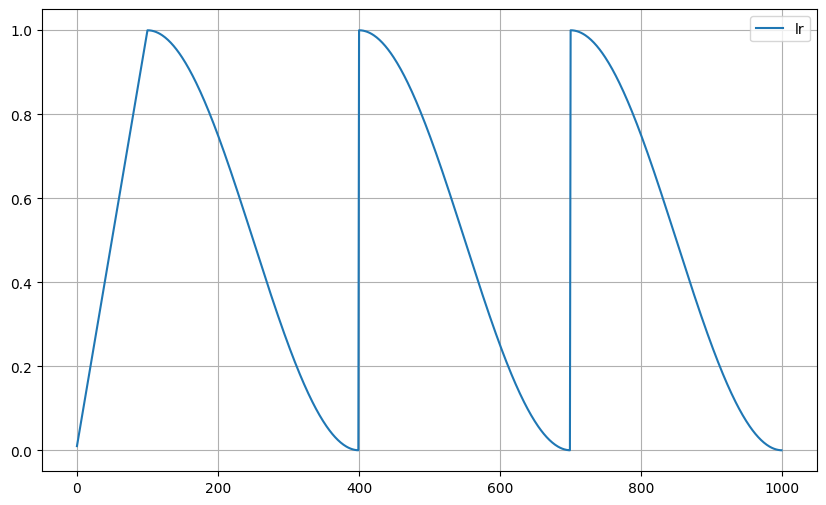

In [70]:
_total_steps = 1000
_warmup_steps = 100
_num_cycles = 3
_steps = range(_total_steps)
_lrs = [warmup_cosine_with_restarts(step, _warmup_steps, _total_steps, _num_cycles) for step in _steps]

plt.figure(figsize=(10, 6))
plt.plot(_steps, _lrs, label='lr')
plt.grid(True)
plt.legend()
plt.show()

In [72]:
RESUME = 'allow'
wandb.init(
    project = "ProjectGenCap",
    resume=RESUME,
    config={
        "model": "LSTM",
        "embedding_dim": EMBEDDING_DIM,
        'num_epochs': NUM_EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "weight_decay": WEIGHT_DECAY,
        "lr_scheduler": 'Cyclic',
        "optimizer" : "ADAM",
        'max_plateau_count': MAX_PLATEAU_COUNT,
        "train_size": train_size,
        'val_size': val_size,
        'drop_out': DROP_OUT,
        'word_embedder': 'own',
        }
    
)
wandb.watch(lstm_model)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vubkk67 (vubkk67-hanoi-university-of-science-and-technology). Use `wandb login --relogin` to force relogin


In [73]:
best_model_filepath = os.path.join(PROJECT_DIR, 'models/lstm.pth')

In [74]:
plateau_count = 0
best_val_loss = sys.float_info.max


for epoch in range(0,NUM_EPOCHS):
    curr_lr = lr_scheduler.get_last_lr()[0]
    start_time = time.time()
    total_train_loss = 0
    
    lstm_model.train()
    loss_sum = 0.0
    
    for train_idx, (images, captions, next_tokens) in enumerate(train_loader):
        images = images.to(device)
        captions = captions.to(device)
        next_tokens = next_tokens.to(device)
        
        optimizer.zero_grad()
        predicted_next_tokens = lstm_model(images, captions)
        
        loss = criterion(predicted_next_tokens, next_tokens)
        loss.backward()
        optimizer.step()
        
        lr_scheduler.step()
        
        total_train_loss += loss.item()
        
    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Average Training Loss for Epoch {epoch+1}: {avg_train_loss:.4f}")
        
    
    lstm_model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for val_idx, (images, captions, next_tokens) in enumerate(val_loader):
            images = images.to(device)
            captions = captions.to(device)
            next_tokens = next_tokens.to(device)
        
            predicted_next_tokens = lstm_model(images, captions)
            
            loss = criterion(predicted_next_tokens, next_tokens)
            total_val_loss += loss.item()
            
        
    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Average Validation Loss for Epoch {epoch+1}: {avg_val_loss:.4f}")      
        
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] completed in {(end_time - start_time)/60:.2f} minutes.")
        
    if avg_val_loss < best_val_loss:
        plateau_count = 0
        best_val_loss = avg_val_loss
        torch.save(lstm_model.state_dict(), best_model_filepath)
        print("Validation loss improved. Saved")
        
    else:
        plateau_count += 1
        print("Validation loss did not improve.")
    print('-' * 50)
    
    wandb.log({
        'epoch': epoch + 1,
        'avg_train_loss': avg_train_loss,
        'avg_val_loss': avg_val_loss,
        'best_val_loss': best_val_loss,
        'starting_lr': curr_lr
    })
    
    if plateau_count == MAX_PLATEAU_COUNT:
        print("AVOID OVF")
        break

    lstm_model.train()
wandb.finish()

    

Average Training Loss for Epoch 1: 9.0411
Average Validation Loss for Epoch 1: 9.0369
Epoch [1/1000] completed in 0.30 minutes.
Validation loss improved. Saved
--------------------------------------------------
Average Training Loss for Epoch 2: 9.0381
Average Validation Loss for Epoch 2: 9.0325
Epoch [2/1000] completed in 0.28 minutes.
Validation loss improved. Saved
--------------------------------------------------
Average Training Loss for Epoch 3: 9.0318
Average Validation Loss for Epoch 3: 9.0248
Epoch [3/1000] completed in 0.28 minutes.
Validation loss improved. Saved
--------------------------------------------------
Average Training Loss for Epoch 4: 9.0215
Average Validation Loss for Epoch 4: 9.0124
Epoch [4/1000] completed in 0.28 minutes.
Validation loss improved. Saved
--------------------------------------------------
Average Training Loss for Epoch 5: 9.0034
Average Validation Loss for Epoch 5: 8.9879
Epoch [5/1000] completed in 0.28 minutes.
Validation loss improved. Sa

avg_train_loss,██▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
avg_val_loss,█▄▅▆▆▆▆▆▆▆▅▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▂▂▂▃▂▃▃▄▃▄▅▄▅▅
best_val_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇███
starting_lr,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇███████████
avg_train_loss,1.20729
avg_val_loss,5.66783
best_val_loss,5.05408
epoch,135
starting_lr,0.0001


In [75]:
print(best_val_loss)
print(avg_train_loss)

5.054079362324306
1.2072940728967152


In [76]:
'''Testing model'''
import torch


lstm_trained_model = LSTM_Custom(
    embed_size=EMBEDDING_DIM,
    vocab_size=len(vocab_npa),
    hidden_size=HIDDEN_DIM,
    pad_idx=pad_idx
    ).to(device)
state_dict = torch.load(best_model_filepath, weights_only=True)
lstm_trained_model.load_state_dict(state_dict)
lstm_trained_model.eval()
pass

<SOS> two dogs is is is of a black dog in the grass <UNK> <EOS> 


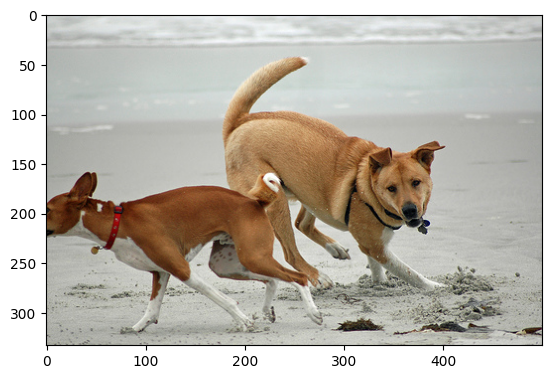

In [77]:
img_path = os.path.join(IMAGE_PATH, df['image'][100])
# img_path = 'test.jpg'
img = transform(Image.open(img_path).convert("RGB"))
img = torch.unsqueeze(img, 0).to(device)


max_caption_len = 30
pad_idx = stoi('<PAD>')
sos_idx = stoi('<SOS>')
eos_idx = stoi('<EOS>')
caption = [[pad_idx for _ in range(max_caption_len)]]
# caption = [[pad_idx]]
caption = torch.tensor(caption).to(device)
caption[0, 0] = sos_idx
caption_str = '<SOS> '

next_idx = 1
with torch.no_grad():
    while next_idx < max_caption_len:
        output = lstm_trained_model(img, caption)
        output = torch.argmax(output).item()

        caption_str += f'{vocab_npa[output]} '
        caption[0, next_idx] = output
        # caption = torch.cat((caption, torch.tensor([[output]]).to(device)), dim=1)
        if output == eos_idx:
            break
        next_idx += 1


plt.imshow(Image.open(img_path).convert("RGB"))
print(caption_str)